## Метод Ньютона

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### 1) решение нелинейных уравнений

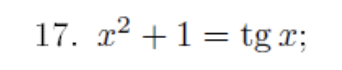

In [2]:
def F(x):
    return x**2 + 1 - np.tan(x)

def dF(x):
    return 2*x - 1/(np.cos(x)*np.cos(x))

def d2F(x):
    return 2 - 2*np.tan(x)*(1/(np.cos(x)*np.cos(x)))

Построим график

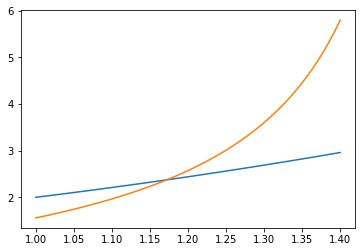

In [3]:
x = np.linspace(1, 1.4, 100)
y1 = x**2 + 1
y2 = np.tan(x)
plt.plot(x, y1)
plt.plot(x, y2)

на графике не видно, но тут больше, чем 1 точка пересечения графиков

### локализация корня - последовательный перебор

[a, b] = [-2pi, 2pi]


In [4]:
def localisation(a, b, N, f):
    
    #a,b - левая/правая границы
    #происходит разбиение отрезка [a, b] на N частей, и
    #в выводе получаем кортеж с обновленной локализацией корня
    
    while True:
        assert a <= b 
        #проверка на то, что права граница больше левой

        step = (b - a) / N
        linspaceAB = [a]

        for i in range(1, N+1):
            linspaceAB.append(a + step * i)
            if f(linspaceAB[-2]) * f(linspaceAB[-1]) < 0:
                return (linspaceAB[-2], linspaceAB[-1])

In [5]:
#тест
a = -2*3.1415
b = 2*3.1415
N = 10

left_bound, right_bound = localisation(a, b, N, F)
left_bound, right_bound

(8.881784197001252e-16, 1.2566000000000006)

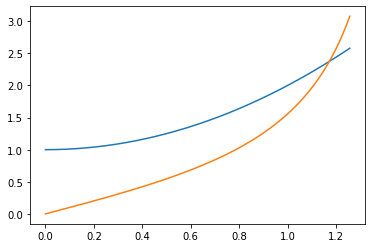

In [6]:
#проверим, действительно ли в определенном промежутке есть корень
x = np.linspace(left_bound, right_bound, 1000)
y1 = x**2 + 1
y2 = np.tan(x)
plt.plot(x, y1)
plt.plot(x, y2)

### метод Ньютона

In [7]:
def NewtonMethod(f, df, a0, b0, x0, eps = 10**(-4)):
    
    #a0, b0 - начальные приближения границ
    #x0 - начальное приближение корня
    #eps - точность
    #метод Ньютона возвращает список из приближений корня;
    #последний элемент - наилучшее приближение
    
    x_list = [] #список приближений
    x_list.append(x0)

    #первый шаг
    x1 = x0 - (f(x0) / df(x0))
    x_list.append(x1)
    bounds = []
    N = 10

    #начальное приближение [a0, b0]
    left_bound, right_bound = a0, b0
    bounds.append((left_bound, right_bound))

    while abs(x_list[-1] - x_list[-2]) > eps:
        xk0 = x_list[-1]

        #корень выходит из рассматриваемого промежутка - применяем дихотомию
        if (xk0 <= left_bound) or (xk0 >= right_bound):
            xk0 = (right_bound + left_bound) / 2

        #Ньютон
        xk1 = xk0 - (f(xk0) / df(xk0))
        x_list.append(xk1)

        #переопределение границ
        left_bound, right_bound = localisation(bounds[-1][0], bounds[-1][1], N, f)
        bounds.append((left_bound, right_bound))

    return x_list

In [8]:
eps = 10**(-4)

a0 = localisation(a, b, N, F)[0]
b0 = localisation(a, b, N, F)[1]
x0 = (a0 + b0)/2.0 + 0.5

NewtonMethod(F, dF, a0, b0, x0, eps)

[1.1283000000000007,
 1.1791591413657072,
 1.172263427919547,
 1.1720937163867635,
 1.1720936172857028]

In [9]:
#тест: крайнее приближение обнуляет функцию!!
F(NewtonMethod(F, dF, a0, b0, x0, eps)[-1])

-1.4477308241112041e-13

## 2) решение систем уравнений

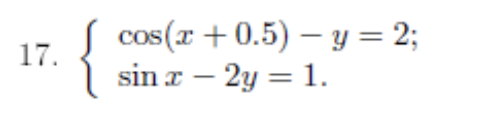

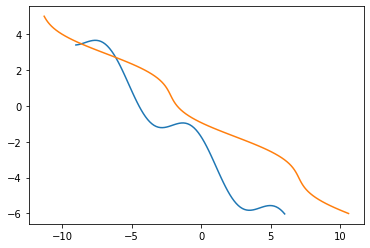

In [10]:
#построим графики
x = np.linspace(-9, 6, 100)
y = np.linspace(-6, 5, 100)

f1 = np.cos(x + 0.5) - y - 2
f2 = np.sin(x) - 2*y - 1

plt.plot(x, f1)
plt.plot(f2, y)

In [11]:
#lambd (лямбда) нужна для второго способа определения 
#начального приближения
def F1(x, y, lambd = 1.0):
    return np.cos(x + 0.5) - y - 2 + (1 - lambd) 

def F2(x, y, lambd = 1.0):
    return np.sin(x) - 2*y - 1 + (1 - lambd)

#частная производная по y
def dF1y(x, y):
    return -1

def dF2y(x, y):
    return -2

#частная производная по x
def dF1x(x, y):
    return -np.sin(x + 0.5)

def dF2x(x, y):
    return np.cos(x)

#### Метод Ньютона (графическое определение начального приближения)

Используется LU-разложение для решения вспомогательной СЛАУ в методе Ньютона

In [12]:
def LUdecomposition(A):
    #тут все действия из второго задания по численным методам - LU-разложение
    #раскладывает матрицу А на матрицы L и U

    dim = len(A)
    L = [[0 for i in range(len(A))] for i in range(len(A))]
    U = [[0 for i in range(len(A))] for i in range(len(A))]
    
    for i in range(dim):
        for j in range(dim):
            if i == j:
                L[i][j] = 1
                
    for i in range(dim):
        for j in range(dim):
            if i <= j:
                U[i][j] = A[i][j] - sum([L[i][k] * U[k][j] for k in range(i)])
            else:
                L[i][j] = (A[i][j] - sum([L[i][k] * U[k][j] for k in range(j)]))/ U[j][j]
    return L, U

def calculateSLAUusingLU(L, U, b):

    #С помощью матриц L, U решаем систему линейных уравнений
    #Получаем списком вектор решения рассматриваемой СЛАУ
   
    dimention = len(b)
    y = [0 for i in range(dimention)]

    #прямой ход
    y[0] = b[0]
    for i in range(1, dimention, 1):
        y[i] = b[i]
        if i == 1:
            y[i] -= L[i][0]*y[0]
        else:
            for j in range(i):
                y[i] -= L[i][j]*y[j]
    
    #обратный ход
    x = [0 for i in range(dimention)]
    x[-1] = y[-1] / U[-1][-1]
    for i in range(dimention - 2, -1, -1):
        x[i] = y[i]
        for j in range(i + 1, dimention, 1):
            x[i] -= U[i][j]*x[j]
        x[i] /= U[i][i]
    return x

In [13]:
def modifiedNewtonMethod2DIM(f1, f2, df1x, df2x, df1y, df2y, x0, l = 1.0, eps = 10**(-4)):

    #x0 - начальное приближение, вектор с компонентами x01, x02
    #лямбда (здесь обозначается как l для краткости) нужна для второго способа определения начального приближения

    #Модифицированный метод Ньютона решения систем нелинейных уравнений (для двумерного случая),
    #для решения вспомогательной СЛАУ - LU-разложение
    #На выходе - список из приближений искомого корня
    
    x_list = []
    x_list.append(x0)

    #(по методичке) partial F(xk)/partial x * δxk = −F(xk) - нужно решить СЛАУ такого вида

    Fx0 = [-f1(x0[0], x0[1], l), 
           -f2(x0[0], x0[1], l)]
        
    dFx0 = [[df1x(x0[0], x0[1]), df1y(x0[0], x0[1])], 
            [df2x(x0[0], x0[1]), df2y(x0[0], x0[1])]]
    
    #решаем СЛАУ LU-разложением
    L, U = LUdecomposition(dFx0)
    delta0 = calculateSLAUusingLU(L, U, Fx0)

    #находим очередное приближение
    x1 = (x0[0] + delta0[0], x0[1] + delta0[1])
    x_list.append(x1)

    #костяк, основа основ, мясо
    #||xk-xk+1|| > eps - критерий остановы
    while ((x0[0] - x1[0])**2 + (x0[1] - x1[1])**2)**(0.5) > eps:
        x0 = x_list[-1]

        #dF(xk) * δxk = −F(xk) - нужно решить СЛАУ такого вида
        Fx0 = [-f1(x0[0], x0[1], l), 
               -f2(x0[0], x0[1], l)]
            
        dFx0 = [[df1x(x0[0], x0[1]), df1y(x0[0], x0[1])], 
                [df2x(x0[0], x0[1]), df2y(x0[0], x0[1])]]
        
        #используем LU-разложение для решения СЛАУ
        L, U = LUdecomposition(dFx0)
        delta0 = calculateSLAUusingLU(L, U, Fx0)

        #находим следующее приближение
        x1 = (x0[0] + delta0[0], x0[1] + delta0[1])
        x_list.append(x1)
    return x_list

#### 1. Графический способ определения начального приближения: 

 Возьмем начальное приближение: (0, 0)



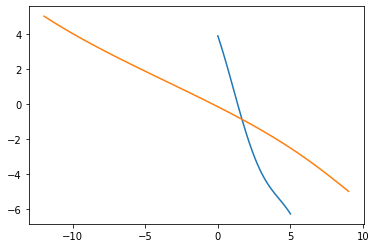

In [14]:
x = np.linspace(0, 5, 100)
y = np.linspace(-5, 5, 100)
f1 = np.cos(x + 0.5) - y - 2
f2 = np.sin(x) - 2*y - 1
plt.plot(x, f1)
plt.plot(f2, y)